In [51]:
from feature_engine.discretisers import EqualWidthDiscretiser, EqualFrequencyDiscretiser
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.max_columns', None) # Print all columns to jupyter notebook

DATA_PATH = r'../data/credit.csv'
DATA_OUTPUT = r'../data/credit_output.csv'

df = pd.read_csv(DATA_PATH)

numeric_cols = [
    'checking_amt',
    'duration',
    'credit_amount',
    'savings',
    'installment_commitment', # Don't think this is categorical
    'residence_since',
    'age',
    'existing_credits',
    'num_dependents'
] 
categorical_cols = list(set(df.columns) - set(numeric_cols))

LOC_REPLACE_THRESHOLD = 8


"""
Remove bad data - Quick removal of rows that contain garbage data
"""
# Remove where rows are almost entirely empty
df = df[df['location'] != '?'] # removes 2 rows
df = df[df['checking_amt'] != '?'] # removes 1 row

# Removes verified as it only has 5 entries and will serve as noise more than anything else
del df['verified']

# After running chi squared analysis on the nominal attributes:

# We noticed that 'purpose' correlated 99% with 'other_parties' outside of missing values so it was safe to remove
del df['purpose']
# We noticed that 'works_outside_US' correlated 100% with 'foreign_worker'
del df['works_outside_US']


"""
Value renaming - structural modifications to data
"""

df['state'] = df['state'].replace('Rhodes Island', 'Rhode Island')

# 'location'
# Remove state abbrv in location. It is already stored in 'state' column
# and has been verified all rows have matching abbrv's and state columns.
df['location'] = df['location'].str.replace('District of Columbia', 'District of Columbia, DC')
df['location'] = df['location'].str.replace('Prince George\'s', 'Prince George')
df['location'] = df['location'].str.split(', ').apply(lambda x: x[0])

# 'property_magnitude'
# Replace the ?s with other and make format consistent.
df['property_magnitude'] = df['property_magnitude'].mask(df['property_magnitude'] == "?", "other")
df['property_magnitude'].replace("'(.*?)'", "\\1", inplace=True, regex=True)


# 'class', 'foreign_worker', 'works_outside_US'
# Make positive and negative values consistent
df['works_outside_US'].replace(['^(1|[Yy]).*', '^(0|[Nn]).*'], ['YES', 'NO'], inplace=True, regex=True)
df['foreign_worker'].replace(['^(1|[Yy]).*', '^(0|[Nn]).*'], ['YES', 'NO'], inplace=True, regex=True)
df['class'].replace(['^([Gg]).*', '^([Bb]).*'], ['GOOD', 'BAD'], inplace=True, regex=True)


# 'employment'
# Replacing missing employment values with unknown
df['employment'] = df['employment'].mask(df['employment'] == "?", "unknown")


# 'personal_status'
# Replacing missing personal_status values with unknown
df['personal_status'] = df['personal_status'].mask(df['personal_status'] == "?", "unknown")
# Remove the single quotes around the data
df['personal_status'].replace("'(.*?)'", "\\1", inplace=True, regex=True)


# 'other_parties'
# Replacing missing other_parties values with unknown
df['other_parties'] = df['other_parties'].mask(df['other_parties'] == "?", "unknown")
# Remove the single quotes around the data
df['other_parties'].replace("'(.*?)'", "\\1", inplace=True, regex=True)


# 'purpose'
# Replacing missing other_parties values with unknown
df['purpose'] = df['other_parties'].mask(df['purpose'] == "?", "unknown")
# Remove the single quotes around the data
df['purpose'].replace("'(.*?)'", "\\1", inplace=True, regex=True)


# 'job'
# Replacing missing other_parties values with unknown
df['job'].mask(df['job'] == "?", "unknown", inplace=True)
# Remove the single quotes around the data
df['job'].replace("'(.*?)'", "\\1", inplace=True, regex=True)

# 'credit_history'
# Replacing missing credit_history values with unknown
df['credit_history'] = df['credit_history'].mask(df['credit_history'] == "?", "unknown")
# Remove the single quotes around the data
df['credit_history'].replace("'(.*?)'", "\\1", inplace=True, regex=True)

# 'other_payment_plans'
# Replacing missing other_payment_plans values with unknown
df['other_payment_plans'] = df['other_payment_plans'].mask(df['other_payment_plans'] == "?", "unknown")
# Remove the single quotes around the data
df['other_payment_plans'].replace("'(.*?)'", "\\1", inplace=True, regex=True)

# 'housing'
# Replacing missing housing values with unknown
df['housing'] = df['housing'].mask(df['housing'] == "?", "unknown")
# Remove the single quotes around the data
df['housing'].replace("'(.*?)'", "\\1", inplace=True, regex=True)

# Replacing missing own_telephone values with unknown
df['own_telephone'] = df['own_telephone'].mask(df['own_telephone'] == "?", "unknown")
# Remove the single quotes around the data
df['own_telephone'].replace("'(.*?)'", "\\1", inplace=True, regex=True)

"""
Value manipulation - semantic modifications to data
"""

# 'checking_amt'
# Bin into 10 equal width bins
df['checking_amt'] = df['checking_amt'].apply(float) # Stored as strings originally
df = df[df['checking_amt'].isna() != True] # removes 1 row
eqdist_discretiser = EqualWidthDiscretiser(
    bins=10, 
    variables=['checking_amt']
)
df = eqdist_discretiser.fit_transform(df)


# 'age'
median = df[df['age'] != '?']['age'].apply(int).median()
df['age'].mask(df['age'] == "?", median, inplace=True)
df['age'] = df['age'].apply(int)
df = df[df['age'].between(0, 100)]

# 'num_dependents'
# Set ?'s to median value, remove unrealistic values
median = df[df['num_dependents'] != '?']['num_dependents'].apply(int).median()
df['num_dependents'].mask(df['num_dependents'] == "?", median, inplace=True)
df['num_dependents'] = df['num_dependents'].apply(int)
df = df[df['num_dependents'].between(0, 5)]

# 'duration'
# Calculate the median of duration and replace missing values with it
median = df[df['duration'] != '?']['duration'].apply(float).median()
df['duration'].mask(df['duration'] == "?", median, inplace=True)
# Convert savings values to float
df['duration'] = df['duration'].apply(float)

# 'installment_commitment'
# Replacing missing installment_commitment values with -1
df['installment_commitment'] = df['installment_commitment'].mask(df['installment_commitment'] == "?", "-1")
df['installment_commitment'] = df['installment_commitment'].apply(int)

# 'residence_since'
# Replacing missing residence_since values with -1
df['residence_since'] = df['residence_since'].mask(df['residence_since'] == "?", "-1")
df['residence_since'] = df['residence_since'].apply(int)

# 'existing_credits'
# Replacing missing existing_credits values with -1
df['existing_credits'] = df['existing_credits'].mask(df['existing_credits'] == "?", "-1")
df['existing_credits'] = df['existing_credits'].apply(int)

# 'savings'
# Calculate the median of savings and replace missing values with it
median = df[df['savings'] != '?']['savings'].apply(float).median()
df['savings'].mask(df['savings'] == "?", median, inplace=True)
# Convert savings values to float
df['savings'] = df['savings'].apply(float)
# Bin by frequency
df['savings'] = pd.qcut(df['savings'], q=10, duplicates='drop').astype(str) 


# 'credit_amount'
# Grab the credit_amount column without ?s
no_miss_credit = df[df['credit_amount'] != "?"]
# Convert to integer
no_miss_credit = no_miss_credit.astype({"credit_amount": float})
# Remove outliers and then calculate the average value
median = float(no_miss_credit['credit_amount'].median())

# Remove all ?s with the calculate average, also remove the outliers again
df['credit_amount'] = df['credit_amount'].mask(df['credit_amount'] == "?", f"{median}")
df = df.astype({"credit_amount": float})

# 'application_date'
# Clean up the date to follow standard datetime format
df['application_date']= pd.to_datetime(df['application_date']) 


# TODO, run attribute grouper first
# # Most locations only have a few entries
# # Replace location with other if less than threshold
# for k, v in df['location'].value_counts().items():
#     if v < LOC_REPLACE_THRESHOLD:
#         df[df['location']  == k] = 'Other'


# Set decision attribute in last column
class_ = df['class']
del df['class']
df.insert(len(df.columns), 'class', class_)


def simplify_location(row):
    if 

# Output to CSV
df.to_csv(DATA_OUTPUT, index=False)

# Status of cleaning for each the column

# location                # Done
# state                   # Done
# checking_amt            # binned, want opinion
# duration                # TODO 89 '?'s, will get to later, currently replacing missing with median
# credit_history          # Done
# purpose               # Done
# credit_amount         # Done, added average as replacement for missing. Maybe bin?
# savings               # Done? maybe don't bin?
# employment            # Done
# installment_commitment # currently replacing ?s with -1 as a category, may need to change
# personal_status       # Done
# other_parties         # Done
# residence_since       # currently replacing ?s with -1 as a category, may need to change
# property_magnitude    # Done, destringified and added "other"
# age                   # Done, replaced outliers with median of column, filtered out outliers, maybe bin?
# other_payment_plans   # Done
# housing               # Done
# existing_credits      # currently replacing ?s with -1 as a category, may need to change
# job                   # Done, replaced ? with unknown
# num_dependents        # Done, Removed bad data. Replaced ? with median
# own_telephone         # 117 ?'s, Currently just replacing with unknown
# foreign_worker        # Done, made yes/no input consistent.
# class                 # Done, made good/bad input consistent.
# verified              # 995 verified, 3 yes, 2 no. Probably should just drop this.
# application_date      # Done. Want opinion. Format as ordinal time or make month/year cols?
# works_outside_US      # Done, made yes/no input consistent.

# Output to CSV

Los Angeles              : 45
Harris                   : 33
Cook                     : 32
Wayne                    : 27
New York                 : 24
Philadelphia             : 16
Maricopa                 : 15
Bexar                    : 15
Dallas                   : 15
Clark                    : 15
Fulton                   : 14
San Francisco            : 13
Marion                   : 12
Orleans                  : 12
Essex                    : 12
Baltimore city           : 12
Jefferson                : 11
Alameda                  : 10
Shelby                   : 9
San Diego                : 9
Orange                   : 9
Sacramento               : 8
St. Louis                : 8
Norfolk                  : 8
Cuyahoga                 : 7
San Bernardino           : 7
Madison                  : 7
El Paso                  : 7
Suffolk                  : 7
De Kalb                  : 7
Camden                   : 6
District of Columbia     : 6
Monroe                   : 6
Travis                   

<AxesSubplot:>

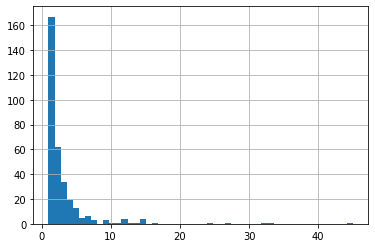

In [61]:
for k, v in df['location'].value_counts().items():
    print(f'{k:<25}: {v}')

df['location'].value_counts().hist(bins=50)

In [63]:
THRESHOLD = 8

for k, v in df['location'].value_counts().items():
    if v < THRESHOLD:
        df[df['location']  == k] = 'Other'

df['location'].value_counts()

Other             606
Los Angeles        45
Harris             33
Cook               32
Wayne              27
New York           24
Philadelphia       16
Bexar              15
Clark              15
Dallas             15
Maricopa           15
Fulton             14
San Francisco      13
Essex              12
Marion             12
Baltimore city     12
Orleans            12
Jefferson          11
Alameda            10
San Diego           9
Orange              9
Shelby              9
St. Louis           8
Sacramento          8
Norfolk             8
Name: location, dtype: int64

In [ ]:
"""
In main script.
"""

# abbrv_map = {
#     'AL': 'Alabama',
#     'AK': 'Alaska',
#     'AZ': 'Arizona',
#     'AR': 'Arkansas',
#     'CA': 'California',
#     'CO': 'Colorado',
#     'CT': 'Connecticut',
#     'DE': 'Delaware',
#     'DC': 'District of Columbia',
#     'FL': 'Florida',
#     'GA': 'Georgia',
#     'HI': 'Hawaii',
#     'ID': 'Idaho',
#     'IL': 'Illinois',
#     'IN': 'Indiana',
#     'IA': 'Iowa',
#     'KS': 'Kansas',
#     'KY': 'Kentucky',
#     'LA': 'Louisiana',
#     'ME': 'Maine',
#     'MD': 'Maryland',
#     'MA': 'Massachusetts',
#     'MI': 'Michigan',
#     'MN': 'Minnesota',
#     'MS': 'Mississippi',
#     'MO': 'Missouri',
#     'MT': 'Montana',
#     'NE': 'Nebraska',
#     'NV': 'Nevada',
#     'NH': 'New Hampshire',
#     'NJ': 'New Jersey',
#     'NM': 'New Mexico',
#     'NY': 'New York',
#     'NC': 'North Carolina',
#     'ND': 'North Dakota',
#     'OH': 'Ohio',
#     'OK': 'Oklahoma',
#     'OR': 'Oregon',
#     'PA': 'Pennsylvania',
#     'RI': 'Rhode Island',
#     'SC': 'South Carolina',
#     'SD': 'South Dakota',
#     'TN': 'Tennessee',
#     'TX': 'Texas',
#     'UT': 'Utah',
#     'VT': 'Vermont',
#     'VA': 'Virginia',
#     'WA': 'Washington',
#     'WV': 'West Virginia',
#     'WI': 'Wisconsin',
#     'WY': 'Wyoming'
# }

# def seperate_locs(row):
#     """
#     This was to verify that every location entry had matching state data.
#     Long story short they did, so this is not actually needed.
#     """
#     try:
#         loc, state_abbrv = row['location'].split(', ')
#     except Exception as e:
#         print(row['location'])
#         raise e
#     row['abbrv'] = abbrv_map[state_abbrv]
#     row['location'] = loc
#     return row['location']
# df['abbrv'] = df.apply(seperate_locs, axis=1)


df['location'] = df['location'].str.replace('District of Columbia', 'District of Columbia, DC')
df['location'] = df['location'].str.split(', ').apply(lambda x: x[0])

In [ ]:
"""
In main script
"""
from feature_engine.discretisers import EqualWidthDiscretiser, EqualFrequencyDiscretiser
import matplotlib.pyplot as plt
df['checking_amt'] = df['checking_amt'].apply(float) # Stored as strings originally
df.hist(column='checking_amt') # Display raw values


# Binning is the way to go? Right now I have equal width.
# Equal frequency maybe? But I don't think so with the distribution
eqdist_discretiser = EqualWidthDiscretiser(
    bins=10, 
    variables=['checking_amt']
)
df = eqdist_discretiser.fit_transform(df)

df.hist(column='checking_amt')


In [ ]:
df['savings'].apply(float).describe()

In [52]:
"""
In main script
"""
# Replacing missing other_parties values with unknown
df['own_telephone'] = df['own_telephone'].mask(df['own_telephone'] == "?", "unknown")
# Remove the single quotes around the data
df['own_telephone'].replace("'(.*?)'", "\\1", inplace=True, regex=True)
df['own_telephone'].value_counts()

none       516
yes        357
unknown    117
Name: own_telephone, dtype: int64

In [ ]:
# Replace the ?s with other
df['property_magnitude'] = df['property_magnitude'].mask(df['property_magnitude'] == "?", "other")
# Remove the single quotes around the data
df['property_magnitude'].replace("'(.*?)'", "\\1", inplace=True, regex=True)
# Display the values as a sanity check
df['property_magnitude'].value_counts()

In [ ]:
"""
In main script
"""
median = df[df['age'] != '?']['age'].apply(int).median()
df['age'].mask(df['age'] == "?", median, inplace=True)
df['age'] = df['age'].apply(int)
df = df[df['age'].between(0, 100)]
df.age.value_counts()

In [ ]:
"""
In main script
"""
# Replacing missing employment values with unknown
df['employment'] = df['employment'].mask(df['employment'] == "?", "unknown")

In [ ]:
"""
In main script
"""

# Replacing missing personal_status values with unknown
df['personal_status'] = df['personal_status'].mask(df['personal_status'] == "?", "unknown")
# Remove the single quotes around the data
df['personal_status'].replace("'(.*?)'", "\\1", inplace=True, regex=True)

In [ ]:
"""
In main script
"""
# Replacing missing other_parties values with unknown
df['other_parties'] = df['other_parties'].mask(df['other_parties'] == "?", "unknown")
# Remove the single quotes around the data
df['other_parties'].replace("'(.*?)'", "\\1", inplace=True, regex=True)

In [ ]:
# Clean up the date to follow standard datetime format
df['application_date']= pd.to_datetime(df['application_date']) 

In [ ]:
# Grab the credit_amount column without ?s
no_miss_credit = df[df['credit_amount'] != "?"]
# Convert to integer
no_miss_credit = no_miss_credit.astype({"credit_amount": float})
# Remove outliers and then calculate the average value
mean = float(no_miss_credit['credit_amount'].mean())

# Remove all ?s with the calculate average, also remove the outliers again
df['credit_amount'] = df['credit_amount'].mask(df['credit_amount'] == "?", f"{mean}")
df = df.astype({"credit_amount": float})

In [ ]:
"""
In main script
"""
# Replacing missing purpose values with unknown
df['purpose'] = df['purpose'].mask(df['purpose'] == "?", "unknown")
# Remove the single quotes around the data
df['purpose'].replace("'(.*?)'", "\\1", inplace=True, regex=True)

In [ ]:
from datetime import date
from dateutil import parser
# Convert to consistent format, set to use ordinal time so it is continious
# Do we want that? Loses distinguishing info on month/year but makes continious
s = df['application_date'].apply(lambda x: parser.parse(x).date().toordinal())

# If we make continious we should also make normalize it.
s = (s - s.min())/(s.max() - s.min())

df['application_date'] = s


In [ ]:
median = df[df['num_dependents'] != '?']['num_dependents'].apply(int).median()
df['num_dependents'].mask(df['num_dependents'] == "?", median, inplace=True)
df['num_dependents'] = df['num_dependents'].apply(int)
df = df[df['num_dependents'].between(0, 5)]
df.num_dependents.value_counts()

# print(known_vals.mean()) # 2093625.787444934
# known_vals = known_vals[known_vals >= 0]
# known_vals = known_vals[known_vals <= 5] # The highest valid value seemed to be 2, but 5 just for good measure
# # print(known_vals.mean()) # 1.1581858407079646
# # print(df[known_vals.index].shape)
# known_vals.median()


In [ ]:
df['job'].value_counts()
# Replacing missing other_parties values with unknown
df['job'].mask(df['job'] == "?", "unknown", inplace=True)
# Remove the single quotes around the data
df['job'].replace("'(.*?)'", "\\1", inplace=True, regex=True)
df['job'].value_counts()

In [ ]:
# This should NOT be run when we are finished
# This naively removes all '?'s just to see some graphs quickly
%matplotlib inline
for col in numeric_cols:
    df = df[df[col] != '?']
    df[col] = df[col].apply(float)
df.hist(figsize=(20,20))
    

In [ ]:
from pandas.plotting import scatter_matrix
scatter_matrix(df[numeric_cols], figsize=(20,20))

In [ ]:
df.corr()

In [ ]:
"""
In main script
"""
# Replacing missing credit_history values with unknown
df['credit_history'] = df['credit_history'].mask(df['credit_history'] == "?", "unknown")
# Remove the single quotes around the data
df['credit_history'].replace("'(.*?)'", "\\1", inplace=True, regex=True)
df['credit_history'].value_counts()

In [49]:
"""
In main script
"""
# Calculate the mean of savings and replace missing values with it
mean = df[df['savings'] != '?']['savings'].apply(float).mean()
df['savings'].mask(df['savings'] == "?", mean, inplace=True)
# Convert savings values to float
df['savings'] = df['savings'].apply(float)
# Bin by frequency
df['savings'] = pd.qcut(df['savings'], q=10, duplicates='drop').astype(str) 
df['savings'].value_counts()

(-0.001, 7.154]      594
(98.282, 9298.08]     99
(7.154, 34.309]       99
(65.862, 98.282]      99
(34.309, 65.862]      99
Name: savings, dtype: int64

In [50]:
"""
In main script
"""
# Replacing missing other_payment_plans values with unknown
df['other_payment_plans'] = df['other_payment_plans'].mask(df['other_payment_plans'] == "?", "unknown")
# Remove the single quotes around the data
df['other_payment_plans'].replace("'(.*?)'", "\\1", inplace=True, regex=True)
df['other_payment_plans'].value_counts()

none       736
bank       123
unknown     87
stores      44
Name: other_payment_plans, dtype: int64

In [51]:
"""
In main script
"""
# Replacing missing housing values with unknown
df['housing'] = df['housing'].mask(df['housing'] == "?", "unknown")
# Remove the single quotes around the data
df['housing'].replace("'(.*?)'", "\\1", inplace=True, regex=True)
df['housing'].value_counts()

own         621
rent        155
unknown     114
for free    100
Name: housing, dtype: int64

In [53]:
"""
In main script
"""
# Calculate the mean of duration and replace missing values with it
mean = df[df['duration'] != '?']['duration'].apply(float).mean()
df['duration'].mask(df['duration'] == "?", mean, inplace=True)
# Convert savings values to float
df['duration'] = df['duration'].apply(float)
df['duration'].value_counts()

12.000000    163
24.000000    156
18.000000    104
20.807991     89
36.000000     78
6.000000      72
15.000000     58
9.000000      44
48.000000     43
30.000000     38
21.000000     28
10.000000     22
27.000000     11
60.000000     11
42.000000      9
11.000000      9
20.000000      8
8.000000       7
4.000000       6
45.000000      5
7.000000       5
39.000000      5
28.000000      3
14.000000      3
22.000000      2
54.000000      2
33.000000      2
13.000000      2
40.000000      1
16.000000      1
5.000000       1
26.000000      1
72.000000      1
Name: duration, dtype: int64

In [55]:
"""
In main script
"""
# Replacing missing housing values with unknown
df['installment_commitment'] = df['installment_commitment'].mask(df['installment_commitment'] == "?", "-1")
df['installment_commitment'] = df['installment_commitment'].apply(int)
df['installment_commitment'].value_counts()

 4    416
 2    211
 3    129
 1    125
-1    109
Name: installment_commitment, dtype: int64

In [ ]:
"""
In main script
"""
# Replacing missing housing values with unknown
df['residence_since'] = df['residence_since'].mask(df['residence_since'] == "?", "-1")
df['residence_since'] = df['residence_since'].apply(int)
df['residence_since'].value_counts()

In [ ]:
"""
In main script
"""
# Replacing missing housing values with unknown
df['existing_credits'] = df['existing_credits'].mask(df['existing_credits'] == "?", "-1")
df['existing_credits'] = df['existing_credits'].apply(int)
df['existing_credits'].value_counts()